In [ ]:
import pandas as pd, numpy as np
import gzip
import os
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import random
import ast
from collections import defaultdict

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import scipy
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

# Check whether GPU is available and can be used
# if CUDA is found then device is set accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    print("Consider changing your run-time to GPU or training will be slow.")

In [ ]:
df = pd.read_csv('data/cleaned_df.csv')

In [ ]:
data = df[['reviewerID', 'asin', 'unexpectedness']].to_dict(orient='records')
train_ratio = 0.99
dataTrain = data[:int(train_ratio*len(data))]
dataValid = data[int(train_ratio*len(data)):]

(1088178, 10992)

In [ ]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for d in dataTrain:
    u,i = d['reviewerID'],d['asin']
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

allItems = list(usersPerItem.keys())
allUsers = list(itemsPerUser.keys())

In [ ]:
userIDs,itemIDs = {},{}
interactions = []

for d in data:
    u,i,r = d['reviewerID'],d['asin'], d['unexpectedness']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((u,i,r))

nUsers,nItems = len(userIDs),len(itemIDs)

In [ ]:
train_ratio = 0.99
interactionsTrain = interactions[:int(train_ratio*len(interactions))]
interactionsValid = interactions[int(train_ratio*len(interactions)):]
len(interactionsTrain), len(interactionsValid)

(1088178, 10992)

In [ ]:
mu = sum([r for _,_,r in interactionsTrain]) / len(interactionsTrain)

In [ ]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        # return self.lamb * (tf.reduce_sum(tf.abs(self.betaU)) +\
        #                     tf.reduce_sum(tf.abs(self.betaI)) +\
        #                     tf.reduce_sum(self.gammaU**2) +\
        #                     tf.reduce_sum(self.gammaI**2))

        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                    tf.reduce_sum(self.betaI**2) +\
                    tf.reduce_sum(self.gammaU**2) +\
                    tf.reduce_sum(self.gammaI**2))

    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred

    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)

        # Calculate Mean Squared Error (MSE)
        mse_loss = tf.nn.l2_loss(pred - r) / len(sampleR)

        # Calculate regularization term using the reg() method
        reg_term = self.reg()

        # Combine MSE loss and regularization term
        total_loss = mse_loss + reg_term

        return total_loss

    def recommend(self, u, num_items=10):
        user_vecs = self.gammaU.numpy()
        item_vecs = self.gammaI.numpy()
        item_bi = self.betaI.numpy().reshape(-1)

        rec_vector = np.add(user_vecs[u, :].dot(item_vecs.T), item_bi)
        item_idx = np.argsort(rec_vector)[::-1][:num_items]
        top_rec_vector = rec_vector[item_idx]

        return item_idx, top_rec_vector


In [ ]:
modelLFM = LatentFactorModel(mu, 100, 1e-5)
optimizer = tf.keras.optimizers.Adam(0.01)

In [ ]:
def trainingStep(model, interactionsTrain, interactionsValid):
    Nsamples = 150000
    loss = 0
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        #loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    train_loss = loss.numpy()

    for u,i,r in interactionsValid:
        sampleU.append(userIDs[u])
        sampleI.append(itemIDs[i])
        sampleR.append(r)

    loss = model(sampleU,sampleI,sampleR)
    #loss += model.reg()

    valid_loss = loss.numpy()

    return train_loss, valid_loss

In [ ]:
train_losses = []
valid_losses = []
for i in range(100):
    train_loss, valid_loss = trainingStep(modelLFM, interactionsTrain, interactionsValid)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Iter #{i+1}: training loss: {train_loss}, valid loss: {valid_loss}")

Iter #1: training loss: 0.0222006943076849, valid loss: 0.02188269980251789
Iter #2: training loss: 0.021987933665513992, valid loss: 0.02179214544594288
Iter #3: training loss: 0.02185378037393093, valid loss: 0.021806733682751656
Iter #4: training loss: 0.021287087351083755, valid loss: 0.0213257297873497
Iter #5: training loss: 0.021370287984609604, valid loss: 0.021398453041911125
Iter #6: training loss: 0.020807655528187752, valid loss: 0.020908651873469353
Iter #7: training loss: 0.021015053614974022, valid loss: 0.021127844229340553
Iter #8: training loss: 0.020776599645614624, valid loss: 0.020934900268912315
Iter #9: training loss: 0.020624106749892235, valid loss: 0.02080892026424408
Iter #10: training loss: 0.020497102290391922, valid loss: 0.02070377767086029
Iter #11: training loss: 0.020263826474547386, valid loss: 0.020506730303168297
Iter #12: training loss: 0.020503006875514984, valid loss: 0.020743323490023613
Iter #13: training loss: 0.02051328308880329, valid loss: 

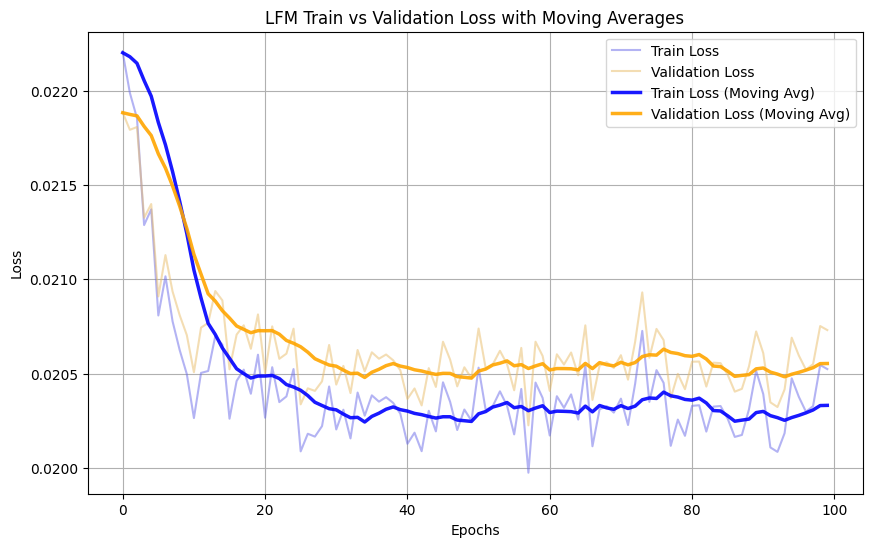

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have train_losses and valid_losses lists containing loss values

# Calculating moving average for better visualization
def moving_average(data, window_size):
    # Pad the data to ensure first window_size elements have a moving average
    padded_data = np.concatenate([data[0] * np.ones(window_size - 1), data])
    moving_avg = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')
    return moving_avg

window_size = 10  # Adjust the window size for the moving average

# Calculate moving averages for train and validation losses
train_losses_ma = moving_average(train_losses, window_size)
valid_losses_ma = moving_average(valid_losses, window_size)

# Plotting the line plot with moving averages
plt.figure(figsize=(10, 6))

# Plotting train and validation losses with a slight tint
plt.plot(train_losses, color='#6969e9', label='Train Loss', alpha=0.5)  # Slightly transparent train loss
plt.plot(valid_losses, color='#e9bc69', label='Validation Loss', alpha=0.5)  # Slightly transparent validation loss

# Plotting moving averages with emphasized colors
plt.plot(train_losses_ma, color='blue', label='Train Loss (10 Moving Avg)', linewidth=2.5, alpha=0.9)  # Emphasized moving average for train loss
plt.plot(valid_losses_ma, color='orange', label='Validation Loss (10 Moving Avg)', linewidth=2.5, alpha=0.9)  # Emphasized moving average for validation loss

plt.title('LFM Train vs Validation Loss with Moving Averages')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('LFM_loss_graph.pdf', format='pdf')

plt.show()



In [ ]:

labels = []
preds = []
for u,i,r in tqdm(interactionsValid):
    labels.append(r)
    pred = modelLFM.predict(userIDs[u], itemIDs[i]).numpy()
    if pred < 0:
        preds.append(0)
    else:
        preds.append(pred)

100%|██████████| 10992/10992 [00:42<00:00, 258.62it/s]


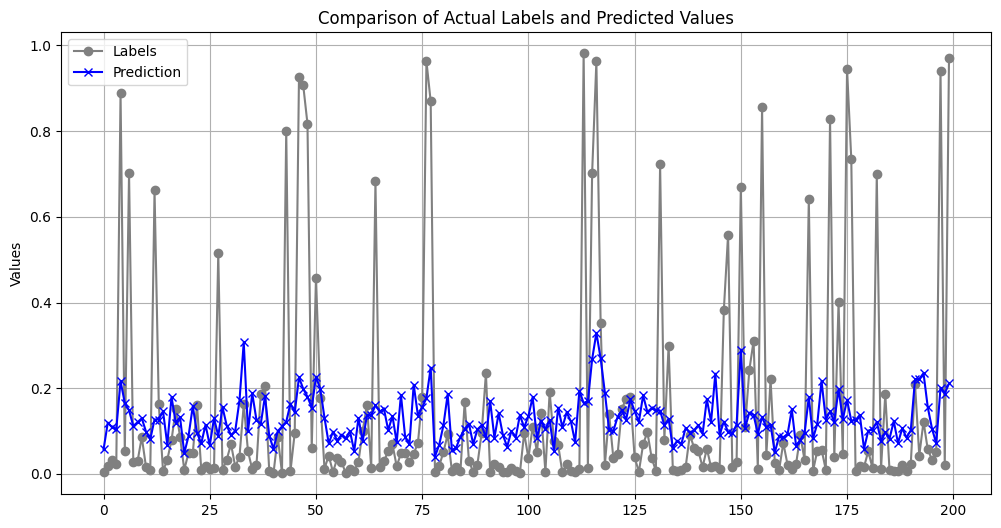

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plotting labels and predicted values
plt.plot(labels[200:400], label='Labels', linestyle='-', marker='o', color='gray')
plt.plot(preds[200:400], label='Prediction', linestyle='-', marker='x', color='blue')

# Adding labels and title
plt.ylabel('Values')
plt.title('Comparison of Actual Labels and Predicted Values')

# Adding legend and grid
plt.legend()
plt.grid(True)

# Show or save the plot
plt.show()

In [ ]:
# Assuming you have created an instance of the LatentFactorModel named 'model'

# Saving the model weights and architecture
modelLFM.save_weights('models/latent_factor_model_weights')  # Save the weights